In [190]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pandas as pd
import numpy as np
import pkg_resources
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import model_bias_analysis

# autoreload makes it easier to interactively work on code in the model_bias_analysis module.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [191]:
model_families = [
    ['Rock:TOXICITY'],#, 'wiki_cnn_v3_101', 'wiki_cnn_v3_102'],
    ['RockV5_1:TOXICITY'],# 'wiki_debias_cnn_v3_101', 'wiki_debias_cnn_v3_102'],
    ['RockV6_1:TOXICITY'],
]

In [192]:
madlibs = pd.read_csv('eval_datasets/bias_madlibs_77k_scored_prod_models.csv')

In [193]:
# Add columns for each subgroup.
f = open('bias_madlibs_data/adjectives_people.txt', 'r')
terms = [line.strip() for line in f]
model_bias_analysis.add_subgroup_columns_from_text(madlibs, 'Text', terms)

In [194]:
madlibs['label_bool'] = madlibs.apply(lambda row: row.Label == 'BAD', axis=1)

In [195]:
madlibs_results = model_bias_analysis.per_subgroup_aucs(madlibs, terms, model_families, 'label_bool')

In [196]:
# madlibs_results['original_pinned_auc'] = madlibs_results.apply(lambda row: row['wiki_cnn_v3_100_aucs'][0], axis=1)
# madlibs_results['debias_pinned_auc'] = madlibs_results.apply(lambda row: row['wiki_debias_cnn_v3_100_aucs'][0], axis=1)

# madlibs_results['original_weighted_pinned_auc'] = madlibs_results.apply(lambda row: row['wiki_cnn_v3_100_normalized_pinned_aucs'][0], axis=1)
# madlibs_results['debias_weighted_pinned_auc'] = madlibs_results.apply(lambda row: row['wiki_debias_cnn_v3_100_normalized_pinned_aucs'][0], axis=1)

In [206]:
madlibs_results['TOXICITY_V1_pinned_auc'] = madlibs_results.apply(lambda row: row['Rock:TOXICITY_aucs'][0], axis=1)
madlibs_results['TOXICITY_V5_pinned_auc'] = madlibs_results.apply(lambda row: row['RockV5_1:TOXICITY_aucs'][0], axis=1)
madlibs_results['TOXICITY_V6_pinned_auc'] = madlibs_results.apply(lambda row: row['RockV6_1:TOXICITY_aucs'][0], axis=1)

madlibs_results['TOXICITY_V1_weighted_pinned_auc'] = madlibs_results.apply(lambda row: row['Rock:TOXICITY_normalized_pinned_aucs'][0], axis=1)
madlibs_results['TOXICITY_V5_weighted_pinned_auc'] = madlibs_results.apply(lambda row: row['RockV5_1:TOXICITY_normalized_pinned_aucs'][0], axis=1)
madlibs_results['TOXICITY_V6_weighted_pinned_auc'] = madlibs_results.apply(lambda row: row['RockV6_1:TOXICITY_normalized_pinned_aucs'][0], axis=1)

madlibs_results['TOXICITY_V1_negative_aeg'] = madlibs_results.apply(lambda row: row['Rock:TOXICITY_within_negative_label_mwus'][0], axis=1)
madlibs_results['TOXICITY_V5_negative_aeg'] = madlibs_results.apply(lambda row: row['RockV5_1:TOXICITY_within_negative_label_mwus'][0], axis=1)
madlibs_results['TOXICITY_V6_negative_aeg'] = madlibs_results.apply(lambda row: row['RockV6_1:TOXICITY_within_negative_label_mwus'][0], axis=1)

madlibs_results['TOXICITY_V1_positive_aeg'] = madlibs_results.apply(lambda row: row['Rock:TOXICITY_within_positive_label_mwus'][0], axis=1)
madlibs_results['TOXICITY_V5_positive_aeg'] = madlibs_results.apply(lambda row: row['RockV5_1:TOXICITY_within_positive_label_mwus'][0], axis=1)
madlibs_results['TOXICITY_V6_positive_aeg'] = madlibs_results.apply(lambda row: row['RockV6_1:TOXICITY_within_positive_label_mwus'][0], axis=1)

In [198]:
madlibs_results.columns

Index([u'Rock:TOXICITY_aucs', u'Rock:TOXICITY_cross_subgroup_negative_mwus',
       u'Rock:TOXICITY_cross_subgroup_positive_mwus', u'Rock:TOXICITY_mean',
       u'Rock:TOXICITY_median', u'Rock:TOXICITY_normalized_pinned_aucs',
       u'Rock:TOXICITY_std', u'Rock:TOXICITY_within_negative_label_mwus',
       u'Rock:TOXICITY_within_positive_label_mwus',
       u'Rock:TOXICITY_within_subgroup_mwus', u'RockV5_1:TOXICITY_aucs',
       u'RockV5_1:TOXICITY_cross_subgroup_negative_mwus',
       u'RockV5_1:TOXICITY_cross_subgroup_positive_mwus',
       u'RockV5_1:TOXICITY_mean', u'RockV5_1:TOXICITY_median',
       u'RockV5_1:TOXICITY_normalized_pinned_aucs', u'RockV5_1:TOXICITY_std',
       u'RockV5_1:TOXICITY_within_negative_label_mwus',
       u'RockV5_1:TOXICITY_within_positive_label_mwus',
       u'RockV5_1:TOXICITY_within_subgroup_mwus', u'RockV6_1:TOXICITY_aucs',
       u'RockV6_1:TOXICITY_cross_subgroup_negative_mwus',
       u'RockV6_1:TOXICITY_cross_subgroup_positive_mwus',
       u'Roc

In [199]:
def bar_chart(results, subgroups, model_1, model_2, y_label):
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(111)
    index = np.arange(len(subgroups))
    bar_width = 0.35

    opacity = 0.4

    rects1 = ax.bar(index, results[model_1], bar_width,
                alpha=opacity, color='b',
                label='Original')

    rects2 = ax.bar(index + bar_width, results[model_2], bar_width,
                alpha=opacity, color='r',
                label='Bias Mitigated')

    ax.set_xlabel('Subgroup')
    ax.set_ylabel(y_label)
    ax.set_title(y_label)
    ax.set_ylim((0.8, 1.0))
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(results['subgroup'], rotation=90)
    ax.legend()

    fig.tight_layout()
    plt.show()

In [231]:
def scatterplot(results, subgroups, model_1, model_2, y_label):
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(111)
    #bar_width = 0.35
    point_size=15
    for i, (_index, row) in enumerate(results.iterrows()):
        # For each subgroup, we plot a 1D scatterplot. The x-value is the position
        # of the item in the dataframe. To change the ordering of the subgroups,
        # sort the dataframe before passing to this function.
        x = [i] * 2
        y = [row[model_1], row[model_2]]
        ax.scatter(x, y, s=0)
        #if (abs(y[1] - y[0]) > 0.003):
        plt.arrow(x[0],y[0], 0, y[1] - y[0], length_includes_head=True, shape='full', head_starts_at_zero=False, head_length=0.005, head_width=0.3, color='black')
    ax.set_xticklabels(results['subgroup'], rotation=90)
    ax.set_xticks(range(len(results)))
    ax.set_ylim((0.5, 1.0))
    ax.set_title(y_label)
    fig.tight_layout()
    #fig.savefig('/tmp/%s_%s.eps' % (file_name, values_col), format='eps')

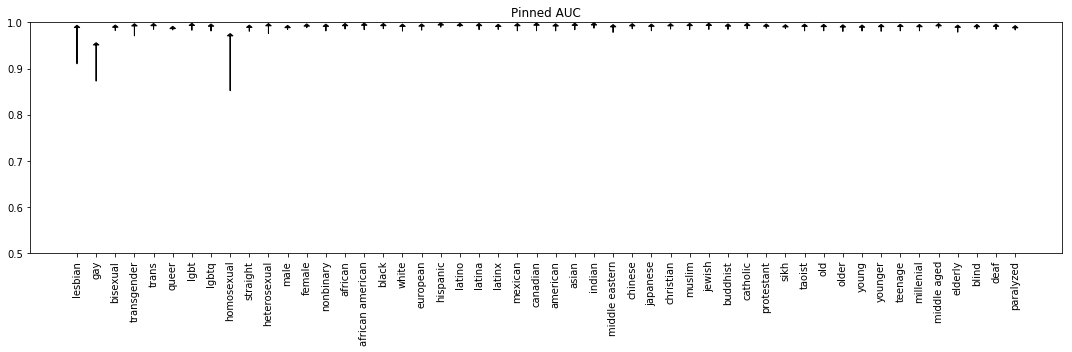

In [232]:
scatterplot(madlibs_results, terms, 'TOXICITY_V1_pinned_auc', 'TOXICITY_V6_pinned_auc', 'Pinned AUC')

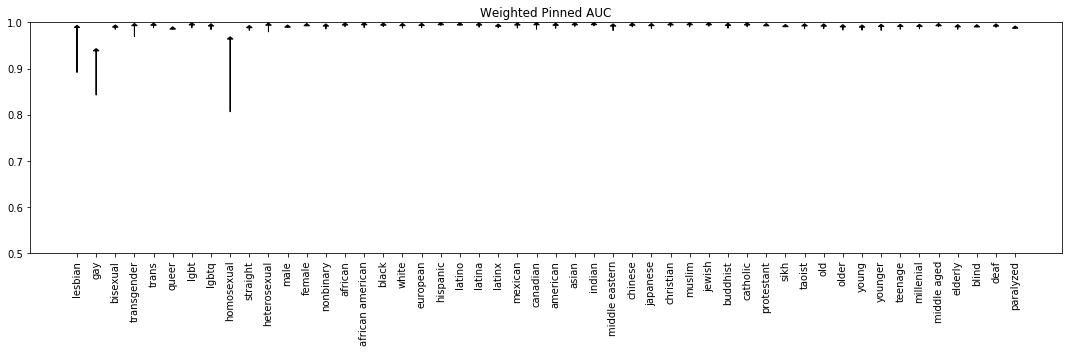

In [233]:
scatterplot(madlibs_results, terms, 'TOXICITY_V1_weighted_pinned_auc', 'TOXICITY_V6_weighted_pinned_auc', 'Weighted Pinned AUC')

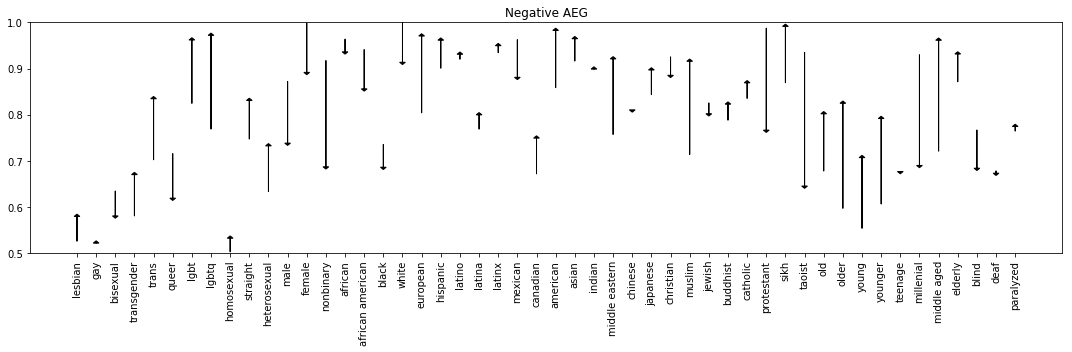

In [234]:
scatterplot(madlibs_results, terms, 'TOXICITY_V1_negative_aeg', 'TOXICITY_V6_negative_aeg', 'Negative AEG')

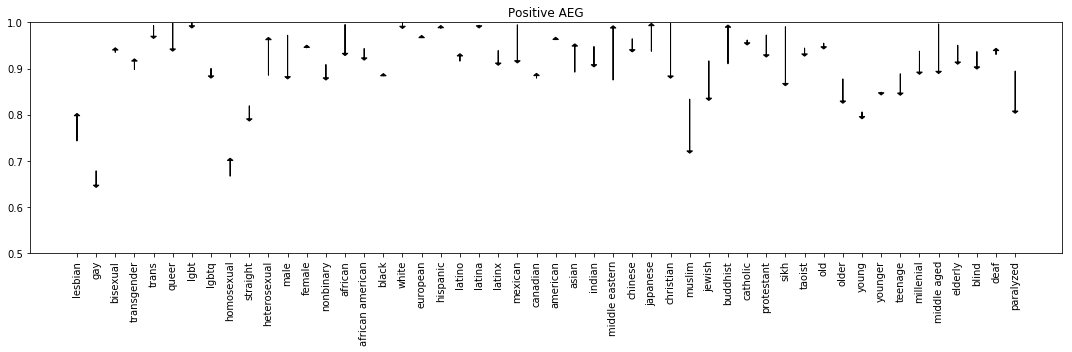

In [237]:
scatterplot(madlibs_results, terms, 'TOXICITY_V1_positive_aeg', 'TOXICITY_V6_positive_aeg', 'Positive AEG')

In [242]:
out = madlibs_results[['subgroup', 'TOXICITY_V1_pinned_auc', 'TOXICITY_V6_pinned_auc', 'TOXICITY_V1_weighted_pinned_auc', 'TOXICITY_V6_weighted_pinned_auc', 'TOXICITY_V1_negative_aeg', 'TOXICITY_V6_negative_aeg', 'TOXICITY_V1_positive_aeg', 'TOXICITY_V6_positive_aeg']]

In [243]:
out.to_csv('eval_datasets/bias_madlibs_77k_scored_prod_models_metrics.csv')